**Angie Carolina Joya Duarte - 2322609**  

**Sheila Marcela Valencia Chito - 2243011**

# Entrega 1 - Perceptrón Multicapa

Se escogió para este trabajo el dataset "Twitter US Airline Sentiment"

## Importación y análisis del dataset

Importamos las librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import nltk

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import pad_sequences, to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.under_sampling import NearMiss, RandomUnderSampler, ClusterCentroids

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definimos las funciones auxiliares para graficar

In [2]:
def graficaDistribucion (dataset, atributo, etiquetas, ejeX, ejeY, titulo):
    graphOutput = sns.countplot(x=atributo, hue=atributo, data=dataset, palette="Set2", legend=False)
    total = len(dataset)

    for p in graphOutput.patches:
        count = p.get_height() #frecuencia absoluta
        percent = 100 * count / total #frecuencia relativa
        
        graphOutput.annotate(f'{percent:.1f}%', # formato de texto
            (p.get_x() + p.get_width() / 2., count/2),  #posición
            ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')
    
    ticks = graphOutput.get_xticks()
    graphOutput.set_xticks(ticks)
    graphOutput.set_xticklabels(etiquetas)    
    graphOutput.set_xlabel(ejeX)
    graphOutput.set_ylabel(ejeY)
    graphOutput.set_title(titulo)

    plt.show()

In [3]:
def graficaEntrenamiento(resultado, set1, set2, titulo, ylabel):
    plt.plot(resultado.history[set1], label="Entrenamiento")
    plt.plot(resultado.history[set2], label="Validación")
    plt.title(titulo)
    plt.xlabel("Época")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [4]:
def graficaMatriz(yTest_labels, yPred_labels):
  # Matriz de confusión
  cm = confusion_matrix(yTest_labels, yPred_labels)
  class_names = ['Negativo', 'Neutro', 'Positivo']

  # Graficar
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Matriz de Confusión")

  plt.xlabel("Predicción")
  plt.ylabel("Etiqueta real")

  plt.show()

Importamos el dataset y lo almacenamos como un dataframe de pandas. Verificamos que no hayan datos faltantes y revisamos la distribución porcentual de los datos para verificar si el conjunto sea representativo

In [5]:
path = os.path.join(os.getcwd(), "Tweets.csv")
dataset = pd.read_csv(path, usecols=[1, 5, 10])
dataset.info()
print("\nAerolíneas:", dataset.airline.unique())
print("Opiniones:", dataset.airline_sentiment.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.3+ KB

Aerolíneas: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
Opiniones: ['neutral' 'positive' 'negative']


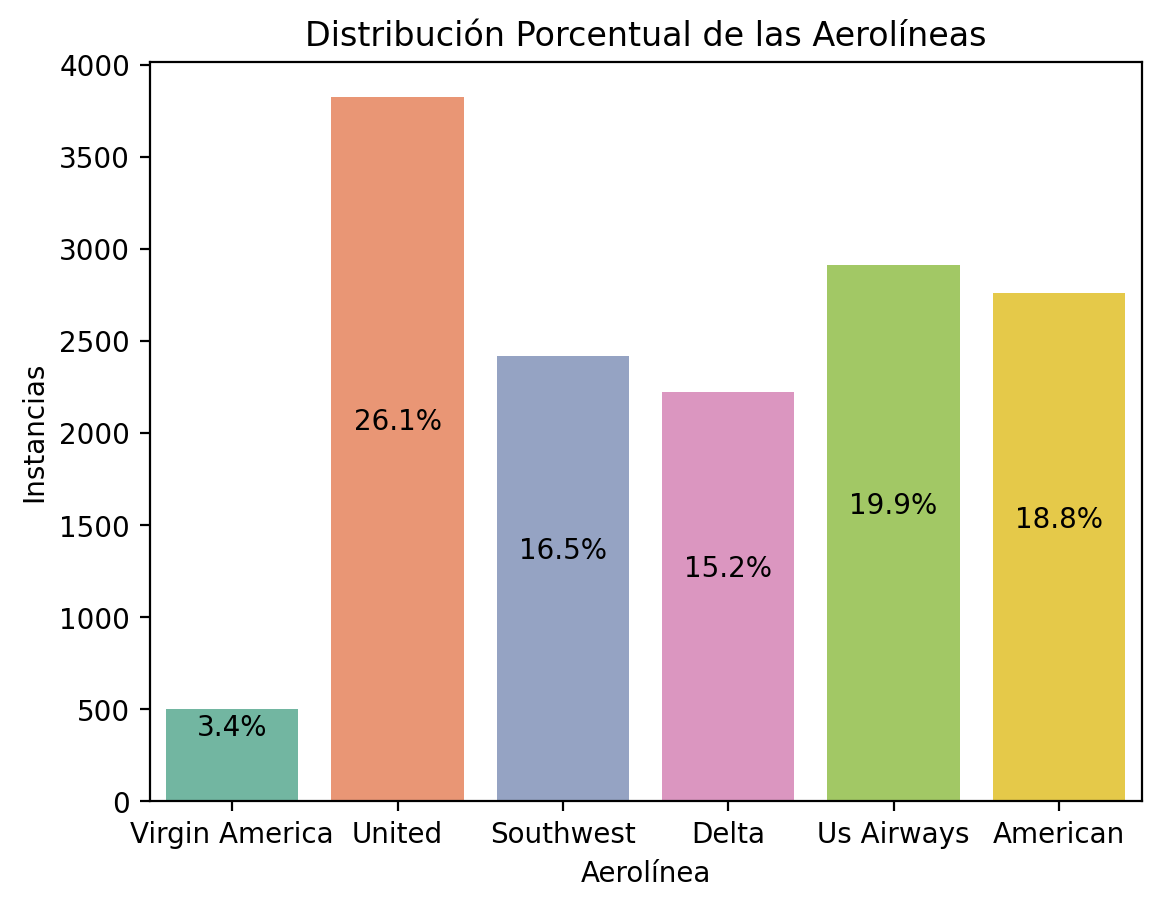

In [6]:
graficaDistribucion(dataset,"airline",["Virgin America", "United", "Southwest", "Delta", "Us Airways", "American"],"Aerolínea","Instancias","Distribución Porcentual de las Aerolíneas")

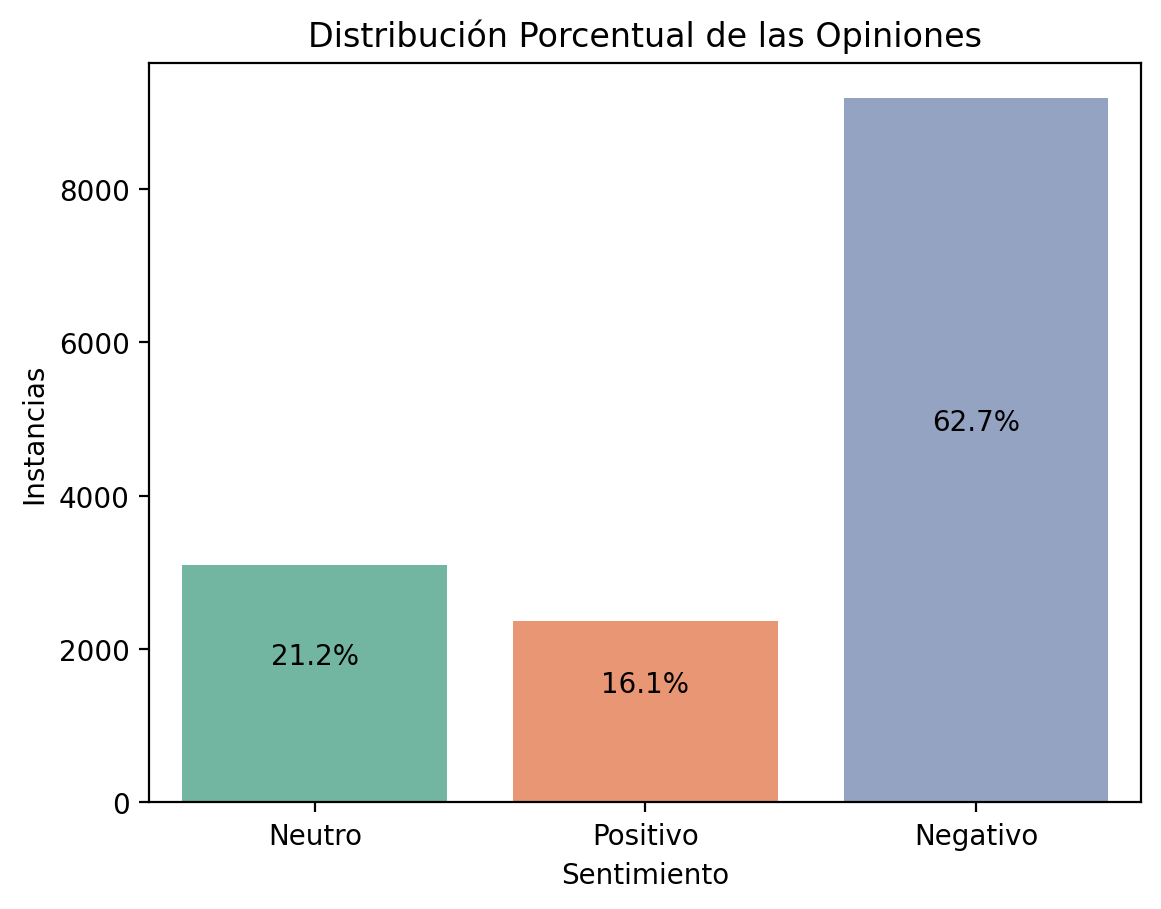

In [7]:
graficaDistribucion(dataset,"airline_sentiment",["Neutro", "Positivo", "Negativo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones")

Hay un desbalanceo en las opiniones, la opinión positiva tiene el 62.7% y la negativa tiene el 16.1%, así que se implementarán técnicas de muestreo para balancear los datos.

## Preprocesamiento de los datos

Representamos las opiniones con etiquetas de enteros: 0 para negativa, 1 para neutra y 2 para genativa

In [8]:
dataset = dataset.drop(["airline"], axis=1)
dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)
dataset = dataset.drop(["airline_sentiment"], axis=1)

C:\Users\USUARIO\AppData\Local\Temp;\ipykernel_10228\2424373769.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)


Procesamos y tokenizamos el texto para poder asignarle representaciones numéricas que se puedan utilizar en la Red Neuronal

In [9]:
nltk.download('stopwords')
palVacias = set(stopwords.words('english')) 
palRaiz = SnowballStemmer('english')
tokenizador = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")

#Además de stopwords, también eliminamos tags (@), links, y el # de los hashtags
usuarios = r"@\w*"
hashtags = r"#(\w+)"
links = r"http\S+"

#Los verbos conjugados en negación no reemplazan por "not" y no se eliminan
negaciones = r"\b(\w+)n't\b"

def preprocesamiento (tweet, stem=True):
    tweet = re.sub(usuarios, "", tweet)
    tweet = re.sub(hashtags, r"\1", tweet)
    tweet = re.sub(links, "", tweet)
    tweet = re.sub(negaciones, "not", tweet, flags=re.IGNORECASE)
    
    palabras = tokenizador.tokenize(tweet)
    texto = []
    
    #Convertimos el texto en un vector de palabras
    for palabra in palabras: 
        palabra_lower = palabra.lower()
        # Conserva "no" y "not" aunque sean stopwords
        if palabra_lower == "not" or palabra_lower == "no" or palabra_lower not in palVacias:
            #Convertir verbos conjugados a su raíz
            if stem:
                texto.append(palRaiz.stem(palabra).lower())
            else:
                texto.append(palabra_lower)
    
    return tokenizador.tokenize(" ".join(texto))

#Aplicar preprocesamiento a todo el dataset
dataset["token"] = dataset.text.map(preprocesamiento)
dataset.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,sentiment,token
0,@VirginAmerica What @dhepburn said.,1,[said]
1,@VirginAmerica plus you've added commercials t...,2,"[plus, ad, commerci, experi, tacki]"
2,@VirginAmerica I didn't today... Must mean I n...,1,"[not, today, must, mean, need, take, anoth, trip]"
3,@VirginAmerica it's really aggressive to blast...,0,"[realli, aggress, blast, obnoxi, entertain, gu..."
4,@VirginAmerica and it's a really big bad thing...,0,"[realli, big, bad, thing]"


Para la representación numérica usamos el algoritmo TF-IDF con una incidencia mínima de 5 y un vocabulario máximo de 2000

In [10]:
vectorizador = TfidfVectorizer(analyzer=lambda x: x, min_df=5, max_features=2000, token_pattern=None)
matriz = vectorizador.fit_transform(dataset["token"])
dataset["rep"] = [row.toarray().flatten().tolist() for row in matriz]
dataset.head()

,text,sentiment,token,rep
0,@VirginAmerica What @dhepburn said.,1,[said],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,@VirginAmerica plus you've added commercials t...,2,"[plus, ad, commerci, experi, tacki]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,@VirginAmerica I didn't today... Must mean I n...,1,"[not, today, must, mean, need, take, anoth, trip]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,@VirginAmerica it's really aggressive to blast...,0,"[realli, aggress, blast, obnoxi, entertain, gu...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,@VirginAmerica and it's a really big bad thing...,0,"[realli, big, bad, thing]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Como la distribución de los datos no está balanceada, implementamos la técnica del Near Miss Centroids para equilibrar los datos.

In [38]:
submuestreo = NearMiss(sampling_strategy='auto',version=2)
#submuestreo = ClusterCentroids(sampling_strategy='auto', random_state=2025)

x = np.array(dataset["rep"].to_list(), dtype="float32")
y = dataset["sentiment"].values
xBal, yBal = submuestreo.fit_resample(x, y)
indicesBal = submuestreo.sample_indices_

datasetBal = dataset.iloc[indicesBal].copy().reset_index(drop=True)
datasetBal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7089 entries, 0 to 7088
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       7089 non-null   object
 1   sentiment  7089 non-null   int64 
 2   token      7089 non-null   object
 3   rep        7089 non-null   object
dtypes: int64(1), object(3)
memory usage: 221.7+ KB


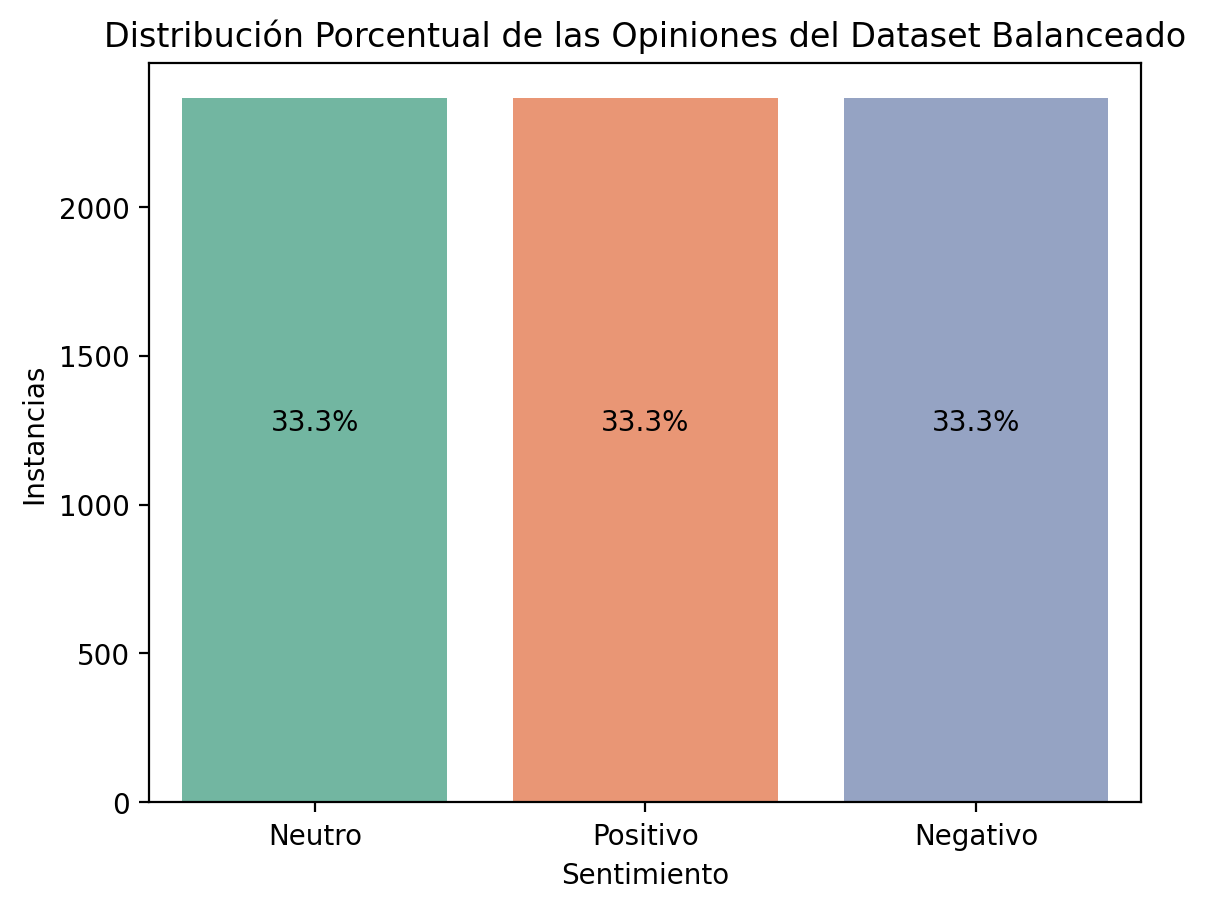

In [39]:
graficaDistribucion(datasetBal,"sentiment",["Neutro", "Positivo", "Negativo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones del Dataset Balanceado")

Luego de realizar el submuestreo podemos convertir la salidas en vectores de binarios usando one hot encoding

In [40]:
datasetBal["one_hot"] = list(to_categorical(datasetBal["sentiment"], num_classes=3))

## Creación y Entrenamiento de la Red Neuronal

Separamos el dataset en 2 conjuntos: 70% para el entrenamiento y 30% para la validación

In [41]:
n = len(datasetBal)
cTrain = int(n*0.7) # 70% para entrenar y 30% para la validación
cTest = n-cTrain

print(f"N = {n} | Tamaño entrenamiento = {cTrain} | Tamaño prueba = {cTest}")

trainData, testData = train_test_split(datasetBal, train_size=cTrain, test_size=cTest, random_state=24601)
trainData.head()

N = 7089 | Tamaño entrenamiento = 4962 | Tamaño prueba = 2127


,text,sentiment,token,rep,one_hot
1404,@united we are sitting on the runway for 2 hou...,0,"[sit, runway, 2, hour, ridicul]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]"
3309,@SouthwestAir yeah it happens. The PHX airport...,1,"[yeah, happen, phx, airport, extra, long, wait...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]"
1333,@united #customerservice at @Dulles_Airport co...,0,"[customerservic, could, not, wors, get, bad, w...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]"
4043,@JetBlue so yesterday a flight I wanted to Chi...,1,"[yesterday, flight, want, chicago, sale, withi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]"
6591,@USAirways I love you guys!!!,2,"[love, guy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0]"


Definimos la arquitectura de la red neuronal

In [42]:
def redNeuronal (entrada, salida):
    modelo = keras.Sequential([
        keras.Input(shape=(entrada,)),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(salida, activation="softmax")
    ])
    opt = Adam(learning_rate=0.00001)
    modelo.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return modelo

Definimos los parámetros de entrenamiento

In [43]:
def entrenamiento (xTrain, yTrain, xTest, yTest, modelo, epocas, lote, es):
    history = modelo.fit(
        xTrain, yTrain,
        validation_data = (xTest, yTest),
        epochs = epocas,
        batch_size = lote,
        callbacks=[es],
        verbose = 1,
        validation_split = 0.1
    )
    return history

Damos el formato correcto a los dataset y definimos los valores de los parámetros de entrenamiento

In [44]:
xTrain = np.array(trainData["rep"].to_list(), dtype="float32")
yTrain = np.array(trainData["one_hot"].tolist())
xTest = np.array(testData["rep"].to_list(), dtype="float32")
yTest = np.array(testData["one_hot"].tolist())

epocas = 200
lote = 32
entrada = np.vstack(trainData.rep.values).shape[1]
salida = np.vstack(trainData.one_hot.values).shape[1]

print("Tamaño de la entrada:",entrada)
print("Tamaño de la salida:",salida)

llamadas = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

Tamaño de la entrada: 2000
Tamaño de la salida: 3


Realizamos el entrenamiento, con una cantidad de épocas determinada por el Early Stopping

In [45]:
modelo = redNeuronal (entrada, salida)
resultado = entrenamiento(xTrain, yTrain, xTest, yTest, modelo, epocas, lote, llamadas)

resultados = {
    "Época": ["Primera", "Última"],
    "Loss": [resultado.history["loss"][0], resultado.history["loss"][-1]],
    "Val_Loss": [resultado.history["val_loss"][0], resultado.history["val_loss"][-1]],
    "Accuracy": [resultado.history["accuracy"][0], resultado.history["accuracy"][-1]],
    "Val_Accuracy": [resultado.history["val_accuracy"][0], resultado.history["val_accuracy"][-1]],
}

tabla = pd.DataFrame(resultados)
print(tabla)

Epoch 1/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3231 - loss: 1.2457 - val_accuracy: 0.3164 - val_loss: 1.2427
Epoch 2/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3372 - loss: 1.2401 - val_accuracy: 0.3183 - val_loss: 1.2381
Epoch 3/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3406 - loss: 1.2359 - val_accuracy: 0.3315 - val_loss: 1.2340
Epoch 4/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3438 - loss: 1.2317 - val_accuracy: 0.3399 - val_loss: 1.2301
Epoch 5/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3529 - loss: 1.2283 - val_accuracy: 0.3484 - val_loss: 1.2265
Epoch 6/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3690 - loss: 1.2241 - val_accuracy: 0.3535 - val_loss: 1.2230
Epoch 7/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3692 - loss: 1.2209 - val_accuracy: 0.3601 - val_loss: 1.2197
Epoch 8/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3789 - loss: 1.2172 - val_accu

Matriz de confusión de la última época

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


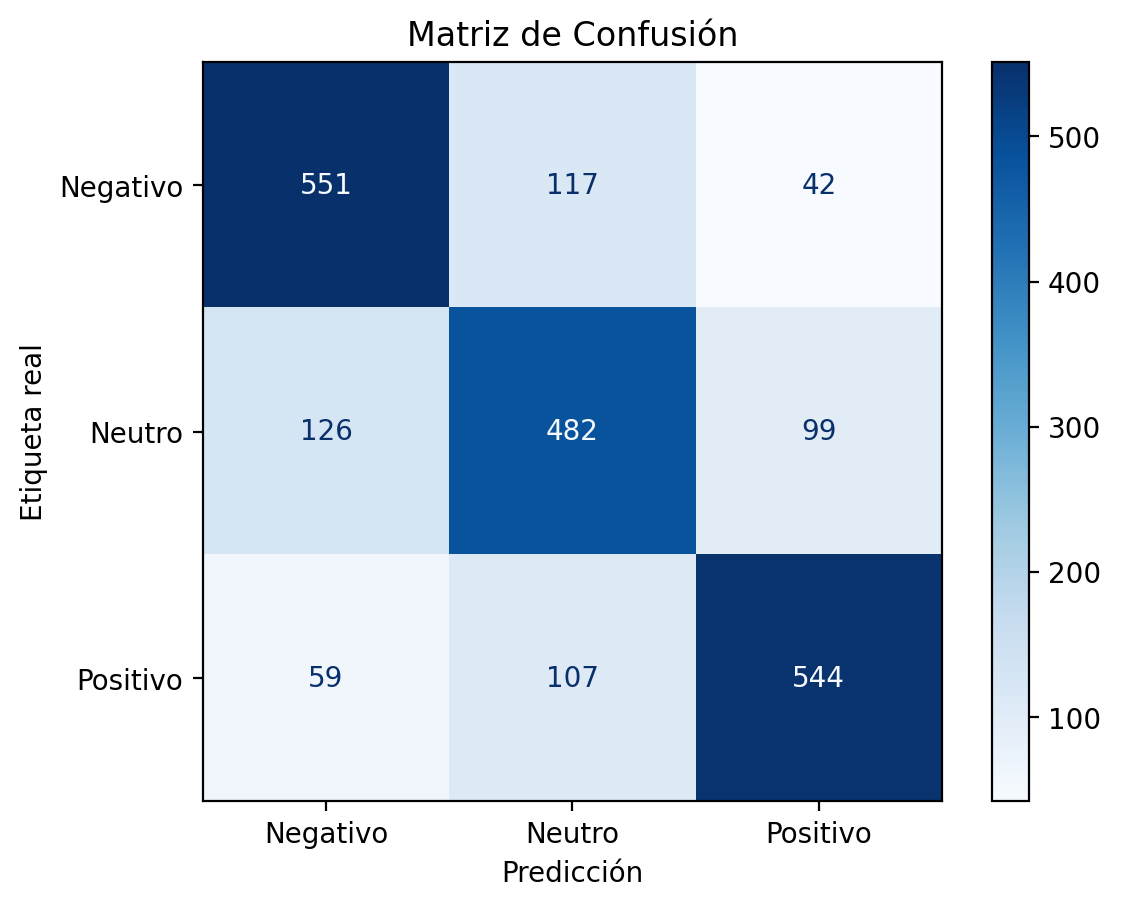

In [46]:
yPred = modelo.predict(xTest)
yPred_labels = np.argmax(yPred, axis=1)
yTest_labels = np.argmax(yTest, axis=1)

graficaMatriz(yTest_labels, yPred_labels)

Accuracy de entrenamiento y validación

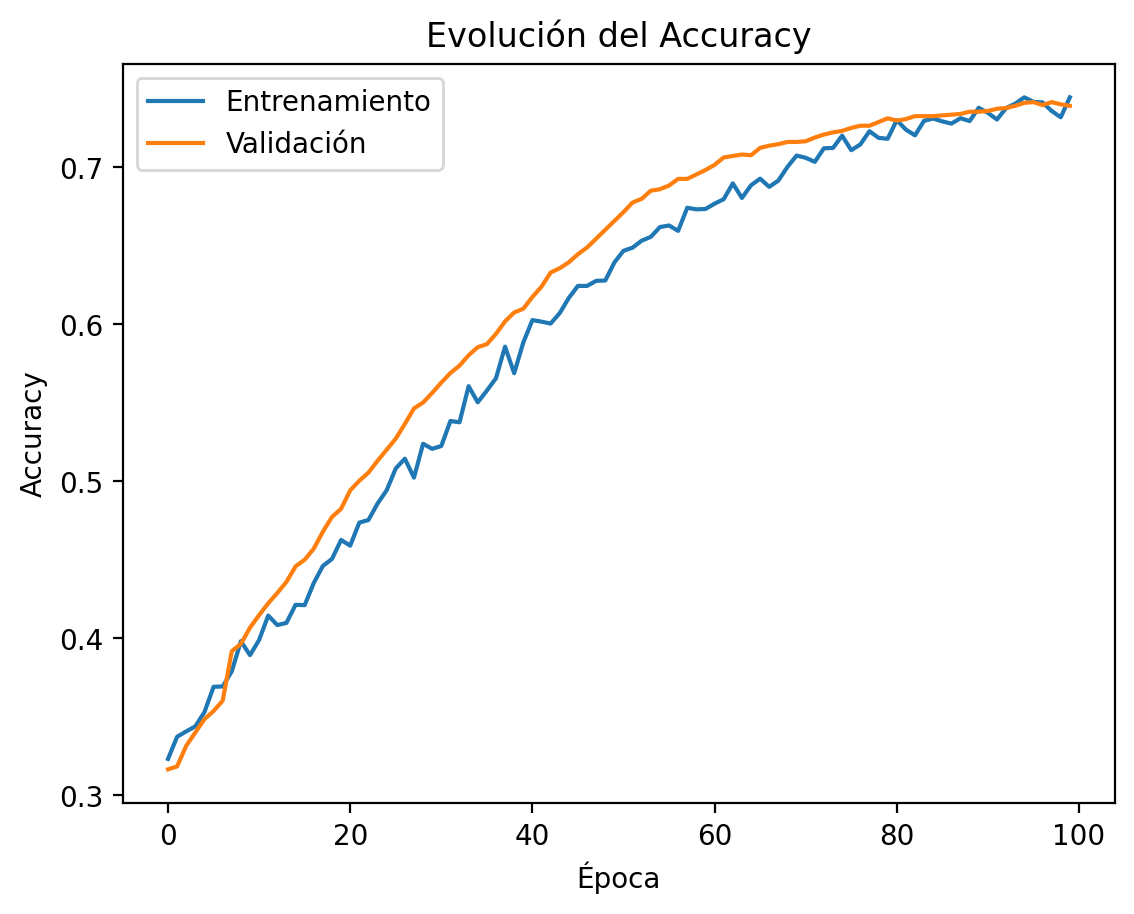

In [47]:
graficaEntrenamiento(resultado, "accuracy", "val_accuracy", "Evolución del Accuracy", "Accuracy")

Pérdidas de entrenamiento y validación

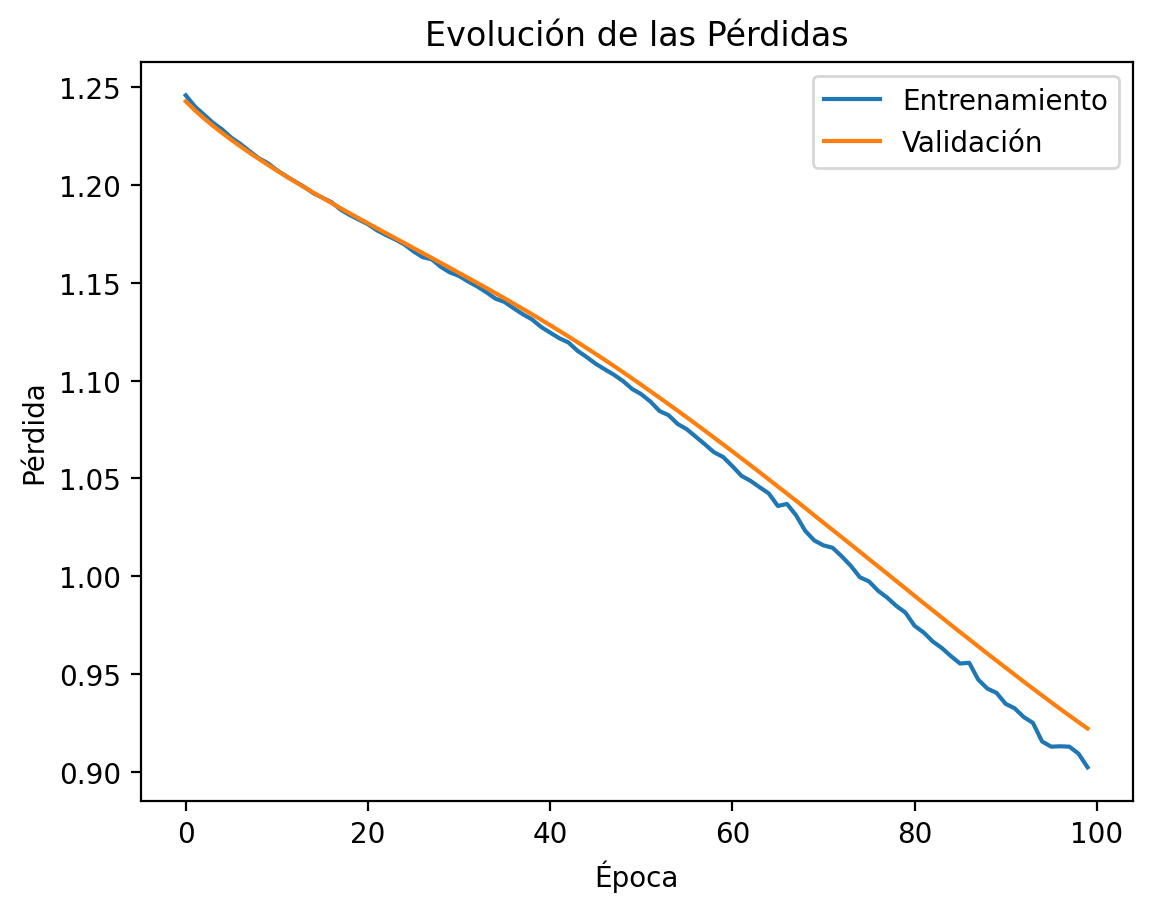

In [48]:
graficaEntrenamiento(resultado, "loss", "val_loss", "Evolución de las Pérdidas", "Pérdida")

## Pruebas preliminares

### Perceptrón - 1 Capa

Optimizador Adagrad. Submuestreo Near Miss

![alt text](acc.png) | ![alt text](loss.png) | ![alt text](output.png)
|-----------------|-------------------|-------------------|

### Sin métodos de regularización

2 capas ocultas: 64 y 32 neuronas. Optimizador Adagrad. Submuestreo Near Miss

![alt text](acc-1.png) | ![alt text](loss-1.png) | ![alt text](output-1.png)
|-----------------|-------------------|-------------------|

2 capas ocultas: 32 y 16 neuronas. Optimizador Adagrad. Submuestreo Near Miss

![alt text](acc-2.png) | ![alt text](loss-2.png) | ![alt text](mc.png)
|-----------------|-------------------|-------------------|

2 capas ocultas: 16 y 16 neuronas. Optimizador Adagrad. Submuestreo Near Miss

![alt text](acc-3.png) |![alt text](loss-3.png) | ![alt text](mc-1.png)
|-----------------|-------------------|-------------------|

### Regularización

Droput en las dos capas ocultas, de 0.2 para ambas

![alt text](<0.2x2 acc.png>) | ![alt text](<0.2x2 loss.png>)
|-----------------|-------------------|

Droput en las dos capas ocultas, de 0.4 para ambas

![alt text](<0.4x2 acc.png>) | ![alt text](<0.4x2 loss.png>)
|-----------------|-------------------|

Droput en las dos capas ocultas, de 0.4 para la primera capa y 0.2 para la segunda

![alt text](acc-4.png) | ![alt text](loss-4.png) | ![alt text](mc-2.png)
|-----------------|-------------------|-------------------|

L2 y función GeLU en ambas capas ocultas. Optimizador Adagrad

![alt text](<adagrad con gelu y l2 acc.png>) | ![alt text](<adagrad con gelu y l2 loss.png>) 
|-----------------|-------------------|

L2 y función ReLU en ambas capas ocultas. Optimizador Adagrad

![alt text](<adagrad con l2 acc.png>) | ![alt text](<adagrad con l2 loss.png>)
|-----------------|-------------------|

L2 y función ReLU en ambas capas ocultas. Optimizador Adam

![alt text](<adam con l2 acc.png>) | ![alt text](<adam con l2 loss.png>)
|-----------------|-------------------|

### Técnicas de Muestreo

Submuestreo Near Miss

![alt text](nm1.png) | ![alt text](nm2.png)
|-----------------|-------------------|

Submuestreo Cluster Centroids

![alt text](cc1.png) | ![alt text](cc2.png)
|-----------------|-------------------|